# Poniendo en práctica lo aprendido

El ejercicio de las siguientes dos clases consistirá en poner en práctica lo aprendido durante las clases pasadas (cálculo de cuantiles, momentos, identificación de valores atípicos) y vamos a añadir la parte computacional (graficar principalmente).

Este ejercicio yo lo realicé hace varios años en un curso de cómputo aquí en la facultad con un profesor excelente, pero utilizamos herramientas un poco más _arcaicas_ (`awk`). Esta vez repetiremos el ejercicio juntos pero con pandas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

## Elecciones presidenciales del 2006

Comenzaremos por cargar el archivo de datos. Se encuentra abajo. Les voy a ayudar pues no es un csv, pero es basicamente lo mismo, sólo que el lugar de usar comas utiliza esta cosa: | (pipe).

El contenido del archivo se encuentra explicado por el mismisimo IFE (cuando aún era IFE, en mis tiempos) en el pdf explicacion.pdf. Léanlo para entender lo que es cada columna (**en verdad háganlo, porque con el ID no les va a ser suficiente. Y a la mejor después de leerlo de todos modos no queda claro...**), conserven los nombres de las columnas aunque sean horribles y largos. Utilicen pues la función `pd.read_csv()` con los argumentos adecuados para cargar el csv a una variable llamada datos.

**TRUCO**: si colocan el cursor en el paréntesis de la función y presionan shift+tab les va a decir cuales son los argumentos que la función espera. Es superútil!

In [2]:
datos = pd.read_csv("Computos2006-Presidente.txt",sep='|')
print("Número de entradas:", datos.shape[0])
datos.head()

Número de entradas: 130788


,ID_ESTADO,DISTRITO,SECCION,ID_CASILLA,TIPO_CASILLA,EXT_CONTIGUA,TIPO_CANDIDATURA,TIPO_ACTA,LISTA_NOMINAL,NO_VOTOS_NULOS,...,ORDEN,PAN,APM,PBT,NA,ASDC,MUNICIPIO,PAQUETE_ENTREGADO,CASILLA_INSTALADA,FECHA_HORA
0,1,1,0,1,B,0,6,NaN,120,0.0,...,1,53.0,4.0,18.0,0.0,1.0,0,NaN,NaN,05/07/2006 23:22:10
1,1,1,338,1,B,0,1,1.0,689,12.0,...,1,202.0,45.0,65.0,12.0,12.0,2,1.0,1.0,05/07/2006 08:17:05
2,1,1,338,1,C,0,1,1.0,689,7.0,...,2,175.0,38.0,56.0,3.0,8.0,2,1.0,1.0,05/07/2006 08:22:24
3,1,1,339,1,B,0,1,1.0,630,0.0,...,3,165.0,50.0,48.0,7.0,13.0,2,1.0,1.0,05/07/2006 08:24:47
4,1,1,339,1,C,0,1,1.0,631,6.0,...,4,174.0,64.0,32.0,9.0,7.0,2,1.0,1.0,05/07/2006 08:25:03


Como pueden ver, se han cargado las 23 columnas descritas en el pdf. Para que sea un poco más entendible a nosotros, vamos a comenzar por reemplazar la columna de ID_ESTADO por ESTADO. El siguiente diccionario mapea los identificadores a los estados correspondientes

In [3]:
id2state = {1: 'Aguascalientes', 2:'Baja California', 3: 'Baja California Sur', 4: 'Campeche',
           5: 'Coahuila', 6: 'Colima', 7: 'Chiapas', 8: 'Chihuahua', 9:'CDMX', 10: 'Durango',
           11: 'Guanajuato', 12: 'Guerrero', 13: 'Hidalgo', 14: 'Jalisco', 15: 'México',
           16: 'Michoacán', 17: 'Morelos', 18: 'Nayarit', 19: 'Nuevo León', 20: 'Oaxaca',
           21: 'Puebla', 22: 'Querétaro', 23: 'Quintana Roo', 24: 'San Luis Potosí',
           25: 'Sinaloa', 26: 'Sonora', 27: 'Tabasco', 28: 'Tamaulipas', 29: 'Tlaxcala',
           30: 'Veracruz', 31: 'Yucatán', 32: 'Zacatecas'}

In [4]:
#Su respuesta aquí
datos["ID_ESTADO"] = datos["ID_ESTADO"].apply(lambda x: id2state[x])
datos.rename(columns = {'ID_ESTADO': 'ESTADO'}, inplace = True)

El archivo contiene sólo los datos para elección presidencial, pero están divididos en dos grupos: Voto extranjero y no extranjero. genere un nuevo DF donde estén los votos del extranjero únicamente, y uno en que estén los votos restantes. En ambos DF puede eliminar la columna `TIPO_CANDIDATURA`. Es una buena práctica en general conservar el arreglo original (nótese que nosotros ya rompimos esa regla al reemplazar el nombre de una de las columnas, pero toda la información sigue ahí)

In [5]:
#Su respuesta aquí
votoExtranjero = datos[datos["TIPO_CANDIDATURA"] == 6]
votoLocal = datos[datos["TIPO_CANDIDATURA"] == 1]

votoExtranjero = votoExtranjero.drop(columns = ["TIPO_CANDIDATURA"])
votoLocal = votoLocal.drop(columns = ["TIPO_CANDIDATURA"])

## Estadística general

Como primera tarea, verifique que los datos que tenemos coinciden con lo reportado por el IFE. Es decir, busque los porcentajes de votaciones para cada partido, el número de votos totales y vea que son los mismos que el IFE anunció. Observe que hay campos de "Votos Nulos", campos de "Votos totales" y campos de "Votos totales". Al comparar con lo reportado en otros lados usted comprenderá mejor lo que significa cada campo.

PAN                  0.358933
PBT                  0.353096
APM                  0.222569
NA                   0.009615
ASDC                 0.027012
NO_VOTOS_CAN_NREG    0.007130
NO_VOTOS_NULOS       0.021646
dtype: float64


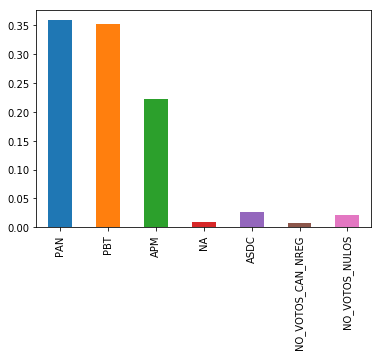

In [33]:
# Su respuesta aquí
partidos = ["PAN", "PBT", "APM", "NA", "ASDC", "NO_VOTOS_CAN_NREG", "NO_VOTOS_NULOS"]
vpp = votoLocal[partidos].sum() + votoExtranjero[partidos].sum()
porcentaje = vpp / vpp.sum()
porcentaje.plot(kind = 'bar')
print(porcentaje)

Primer observación: para que los números cuadren, se toma en la cuenta del total de votos los votos nulos, si no, el porcentaje reportado por el [IFE](http://portalanterior.ine.mx/documentos/Estadisticas2006/presidente/nac.html) no es el mismo. Sin aún levantar sospechas, el número de votos nulos es del 2%, que sería suficiente para cambiar los resultados de la elección. Esto no lo podemos verificar con esta base de datos. Sin embargo, viendo únicamente el voto extranjero vemos que la diferencia era un poco más grande.

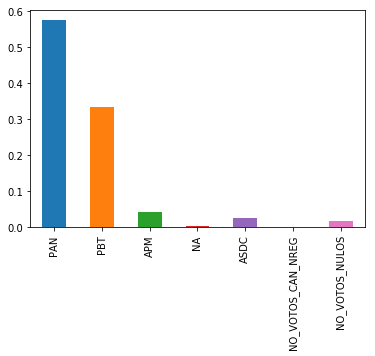

In [40]:
(votoExtranjero[partidos].sum() / votoExtranjero[partidos].sum().sum()).plot(kind='bar')

## Búsqueda de anomalías

Lo primero es ver el tipo de datos que tenemos ahora. Conteste las siguientes preguntas.

#### 1.1 NaN's (información faltante)

Hay Nan's en algunas columnas? Cuáles? Qué importancia tiene esto?

In [43]:
# Su respuesta aquí
datos.isna().any()

ESTADO               False
DISTRITO             False
SECCION              False
ID_CASILLA           False
TIPO_CASILLA         False
EXT_CONTIGUA         False
TIPO_CANDIDATURA     False
TIPO_ACTA             True
LISTA_NOMINAL        False
NO_VOTOS_NULOS        True
NO_VOTOS_CAN_NREG     True
NO_VOTOS_VALIDOS      True
TOTAL_VOTOS          False
ORDEN                False
PAN                   True
APM                   True
PBT                   True
NA                    True
ASDC                  True
MUNICIPIO            False
PAQUETE_ENTREGADO     True
CASILLA_INSTALADA     True
FECHA_HORA           False
dtype: bool

Las columnas en las que hay información faltante son TIPO_ACTA, NO_VOTOS_NULOS, NO_VOTOS_CAN_NREG, NO_VOTOS_VALIDOS, en todos los partidos, en PAQUETE_ENTREGADO y en CASILLA_INSTALADA. Antes de brincar a juzgar y lanzar hashtags a diestra y siniestra, hay que ver si encontramos patrón alguno en estas faltas de información: es decir, si las faltas de información no favorecen a partido alguno entonces podemos asumir son simples errores.

El siguiente ejercicio va a ser ver qué ocurre con los casos en que CUALQUIERA de los partidos tiene información faltante. Lo que vemos (añadiendo la columna "CASILLA_INSTALADA") es que los NaN's vienen de casillas que no fueron instaladas (es decir, no hay beneficio alguno):

In [59]:
votoLocal[votoLocal[partidos].isna().any(axis = 1)][partidos +["CASILLA_INSTALADA"]]

,PAN,PBT,APM,NA,ASDC,NO_VOTOS_CAN_NREG,NO_VOTOS_NULOS,CASILLA_INSTALADA
70696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
70697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
87864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


ahora, qué ocurre con las casillas en que "NO_VOTOS_VALIDOS" es cero? Hay que verificar que sean las mismas casillas en que los partidos tienen NaN's

In [71]:
(datos[datos["NO_VOTOS_VALIDOS"].isna()].index == datos[datos[partidos].isna().any(axis=1)].index).all()

True

#### 1.2 Lista nominal

Calcule el porcentaje de participación al comparar con la gente que estaba anunciada para votar: es decir, sume los valores de las listas nominales y comparelos con los votos totales. Este número **no** puede ser mayor al número de votos, y note porfavor que sólo porque el resultado global acatará esto, no quiere decir que en cada casilla haya ocurrido. Busque **casilla por casilla** si en verdad hay menos votos que gente en las listas nominales.

In [79]:
#Respuesta aquí
(datos["LISTA_NOMINAL"] <= datos["TOTAL_VOTOS"]).sum()

944

Hay 944 casillas en donde la lista nominal contiene menos gente que el número de votos registrados. Qué raro... vamos a ver exactamente que características hay en estas casillas.

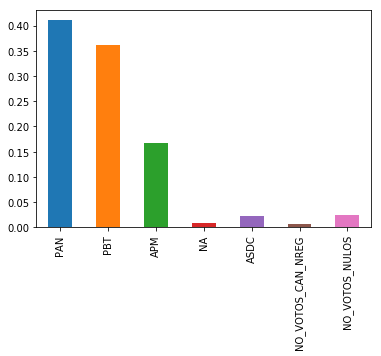

In [88]:
votoAnomalo = datos[datos["LISTA_NOMINAL"] <= datos["TOTAL_VOTOS"]]
(votoAnomalo[partidos].sum() / votoAnomalo[partidos].sum().sum()).plot(kind = 'bar')

Pues, el resultado entre los primeros dos lugares no está tan alejad como para poder decir que aquí hay algún beneficiado. Sin embargo, no se debe dejar de señalar que el manejo de datos **no** está siendo correcto, pues este tipo de errores no se deberían de dar.

Vamos a ir un poco más de fondo y vamos a buscar casillas en donde sólo haya votos para un único partido.

In [96]:
datos[(datos[partidos] == 0).sum(axis=1) == len(partidos)-1][partidos]

,PAN,PBT,APM,NA,ASDC,NO_VOTOS_CAN_NREG,NO_VOTOS_NULOS
10655,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10761,0.0,0.0,187.0,0.0,0.0,0.0,0.0
11377,0.0,39.0,0.0,0.0,0.0,0.0,0.0
32363,104.0,0.0,0.0,0.0,0.0,0.0,0.0
41852,0.0,85.0,0.0,0.0,0.0,0.0,0.0
87244,0.0,50.0,0.0,0.0,0.0,0.0,0.0
88292,0.0,0.0,201.0,0.0,0.0,0.0,0.0
88297,0.0,0.0,351.0,0.0,0.0,0.0,0.0
111000,0.0,2.0,0.0,0.0,0.0,0.0,0.0


Si no es un resultado significativo, vaya que levanta sospechas que una casilla tenga el 100% de votos para un partido. Se podría relajar esta condición a algo que estadisticamente sea imposible (una casilla muy alejada de la estadística general).

In [116]:
#Porcentaje por casilla
ppc = datos[partidos].apply(lambda row: row / row.sum(),axis = 1)
ppc.head()

,PAN,PBT,APM,NA,ASDC,NO_VOTOS_CAN_NREG,NO_VOTOS_NULOS
0,0.697368,0.236842,0.052632,0.000000,0.013158,0.000000,0.000000
1,0.572238,0.184136,0.127479,0.033994,0.033994,0.014164,0.033994
2,0.587248,0.187919,0.127517,0.010067,0.026846,0.036913,0.023490
3,0.583039,0.169611,0.176678,0.024735,0.045936,0.000000,0.000000
4,0.585859,0.107744,0.215488,0.030303,0.023569,0.016835,0.020202


In [124]:
(ppc > 0.9).sum()

PAN                    8
PBT                  125
APM                   60
NA                     0
ASDC                   0
NO_VOTOS_CAN_NREG      0
NO_VOTOS_NULOS         2
dtype: int64

Es curioso que según estos datos, la victoria del PAN fue un poco más homogenea. Si se realiza esto con las votaciones del estado de México en 2017, los resultados son **muy interesantes**. Note que esto puede tener dos razones: Hay una zona donde la estadística no se refleja, es decir, la zona en verdad es muy creyente a un partido, o hay _acarreados_. La segunda es más probable.

## Estadística por estados

#### 2.1 Participación

Comienze por calcular cuántos votos hubo por estado (busque lo que hace la función `groupby` de pandas) y comparelos con la lista nominal de dicho estado (la suma, vaya). Cuál fue el estado con la participación más alta?

In [125]:
# Su respuesta aquí
votoLocal.groupby(["ESTADO"])["TOTAL_VOTOS"].sum()

ESTADO
Aguascalientes          413578
Baja California         949383
Baja California Sur     180796
CDMX                   4833883
Campeche                312486
Chiapas                1272502
Chihuahua              1160629
Coahuila                929479
Colima                  257849
Durango                 571570
Guanajuato             1958734
Guerrero                991283
Hidalgo                 945076
Jalisco                2906184
Michoacán              1492436
Morelos                 708256
México                 5697682
Nayarit                 365499
Nuevo León             1767865
Oaxaca                 1348485
Puebla                 1982868
Querétaro               659807
Quintana Roo            385584
San Luis Potosí         951056
Sinaloa                 980223
Sonora                  933778
Tabasco                 910992
Tamaulipas             1225218
Tlaxcala                410093
Veracruz               2941376
Yucatán                 788990
Zacatecas               524551
N

## Mapa de preferencias

Utilice Folium para indicar _qué color era cada estado_. Es decir, utilice `groupby` nuevamente para clasificar por estados, y encuentre el máximo de las columnas "PAN", "APM", "PBT", "NA" y "ASDC". Puede utilizar el vector de colores definido al principio para colorear los estados.

In [126]:
def party2color(feature, mayorias):
    colors = {'PAN': "#2f35e5", 'APM': "#32d24b", 'PBT': "#e6d775"} #Los demás no van a aparecer.
    return colors[mayorias.loc[feature["properties"]["NOM_ENT"]]]

In [127]:
# Calcule la serie de mayorías: Como ID debe estar el estado, como columna una llamada "Ganador" que contenga
# el nombre de la columna ganadora de votos
mayorias = votoLocal.groupby("ESTADO")[["PAN", "APM", "PBT", "NA", "ASDC"]].sum().idxmax(axis=1)

mexLocation = [23, -96]
mexmap = folium.Map(location=mexLocation, zoom_start=5, tiles='OpenStreetMap')
folium.GeoJson(open("mexican_states.geojson", encoding = 'utf-8').read(),
               style_function = lambda feature:{
                   'fillColor': party2color(feature, mayorias),
                   'fillOpacity': 0.8,
                   'color': 'black',
                   'weight': 1
}).add_to(mexmap)
mexmap

Como una pequeña conclusión, es importante que nosotros sepamos hacer estos cálculos, _nunca sobran ojos para vigilar decisiones de esta magnitud_, pero tampoco hay que ser paranóicos o conspiromaniacos. Si algo chueco hubo en las elecciones de modo que alteró el resultado final, es muy probable que se haya hecho de tal modo que no se reflejó en la base de datos.